# **Animals 10 InceptionV3 Transfer Learning Classifier**
This classifier stems from [this dataset](https://www.kaggle.com/alessiocorrado99/animals10). It pulls together a dataset of 10 animals:

1. Butterflies
2. Cats
3. Cows
4. Dogs
5. Elephants
6. Hens
7. Horses
8. Sheeps
9. Spiders
10. Squirrels

It offers a great opportunity to classify more than just two animals ([dogs vs cats](https://www.kaggle.com/c/dogs-vs-cats)) and broaden the scope of what is possible for CNNs.

The out of the box dataset did need a bit of re-work. I discovered a few other people who created explicit train, test, validate directories and separated the images between the three directories. 

I decided to append the name of the animal to the beginning of each file name. This helped with labeling the data by parsing the filenames and adding a category column in the dataframe.

Then I decided to solely use a training directory, which forgoes the use of a test directory unfortunately. So, this notebook does not include testing of the network that I trained.

The architecture is very similar to the [dogs vs cats classifier model 3](https://github.com/tlapinsk/colab-examples/blob/master/examples/dogs_vs_cats_classifier_3.ipynb) and achieves similar performance.

**Results:** 83% training accuracy

InceptionV3 did not perform well. I even tested on more epics (25+) and it wouldn't push past 83% accuracy. I will be trying to train one from scratch next.


In [1]:
! git clone https://github.com/tlapinsk/colab-examples.git

Cloning into 'colab-examples'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 65055 (delta 34), reused 51 (delta 18), pack-reused 64986
Receiving objects: 100% (65055/65055), 1.39 GiB | 50.58 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Checking out files: 100% (65778/65778), done.


In [2]:
! ls

colab-examples	sample_data


In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from skimage import io, transform
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
import random
import time
from sklearn.model_selection import train_test_split
seed = 333
np.random.seed(seed)

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation,MaxPooling2D,GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

import os
print(os.listdir("colab-examples/data"))

Using TensorFlow backend.


['animals-10', '.DS_Store', 'dogs-vs-cats']


In [4]:
# path to images
img_dir = "colab-examples/data/animals-10"

# list all available images type
print(os.listdir(img_dir))

['test', 'train']


In [5]:
# Split animals into distinct categories
filenames = os.listdir("colab-examples/data/animals-10/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'butterfly':
        categories.append(0)
    elif category == 'cat':
        categories.append(1)
    elif category == 'cow':
        categories.append(2)
    elif category == 'dog':
        categories.append(3)
    elif category == 'elephant':
        categories.append(4)
    elif category == 'hen':
        categories.append(5)
    elif category == 'horse':
        categories.append(6)
    elif category == 'sheep':
        categories.append(7)
    elif category == 'spider':
        categories.append(8)
    elif category == 'squirrel':
        categories.append(9)
    else:
        categories.append(10)

        
print(len(filenames))
print(len(categories))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Preview changes
df.head()

28165
28165


,filename,category
0,horse.OIP-Junvfw6M-f5CciCfImQHRgAAAA.jpeg,6
1,hen.OIP-4ovqN-DFebpVa0aMlUVN0QHaFj.jpeg,5
2,cat.1578.jpeg,1
3,horse.OIP-XeRVyi3T2sAqk5mQMnJU-gHaFy.jpeg,6
4,sheep.ea36b60a2bf6063ed1584d05fb1d4e9fe777ead2...,7


In [6]:
# Preview changes
df.tail()

,filename,category
28160,squirrel.OIP-sXIcPdXaXw6WgzIpQ06f8AHaE8.jpeg,9
28161,elephant.OIP-QW63Hk_VfJviqoFl82EWLwHaEo.jpeg,4
28162,horse.OIP-0xPQHzcoD6qCNx6JXlwblQHaE7.jpeg,6
28163,horse.OIP-0ee38XjYJ5lMmv-ZIhi4MAHaHa.jpeg,6
28164,elephant.OIP-DfhklgZ0XNWBAA8sECtMdAHaFL.jpeg,4


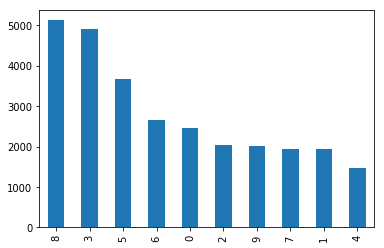

In [7]:
# Check out totals in a bar graph
df['category'].value_counts().plot.bar()

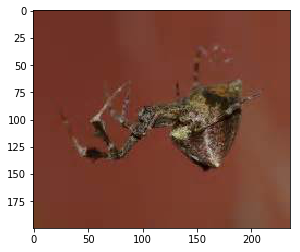

In [8]:
# Random sample image
sample = random.choice(filenames)
image = load_img("colab-examples/data/animals-10/train/"+sample)
plt.imshow(image)

In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False)

CLASSES = 10

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)














87916544/87910968 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

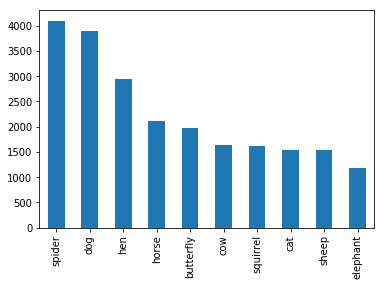

In [11]:
df["category"] = df["category"].replace({0: 'butterfly', 1: 'cat', 2: 'cow', 3: 'dog', 4: 'elephant', 5: 'hen', 6: 'horse', 7: 'sheep', 8: 'spider', 9: 'squirrel', 10: 'none'}) 

# Split into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

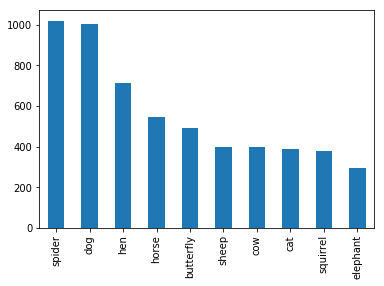

In [12]:
validate_df['category'].value_counts().plot.bar()

In [0]:
total_train    = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size     = 32
epochs         = 50

In [14]:
# Set some variables
IMAGE_WIDTH    = 200
IMAGE_HEIGHT   = 200
IMAGE_SIZE     = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Build training generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "colab-examples/data/animals-10/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 22532 validated image filenames belonging to 10 classes.


In [15]:
# Build validation generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "colab-examples/data/animals-10/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5633 validated image filenames belonging to 10 classes.


In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "colab-examples/data/animals-10/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


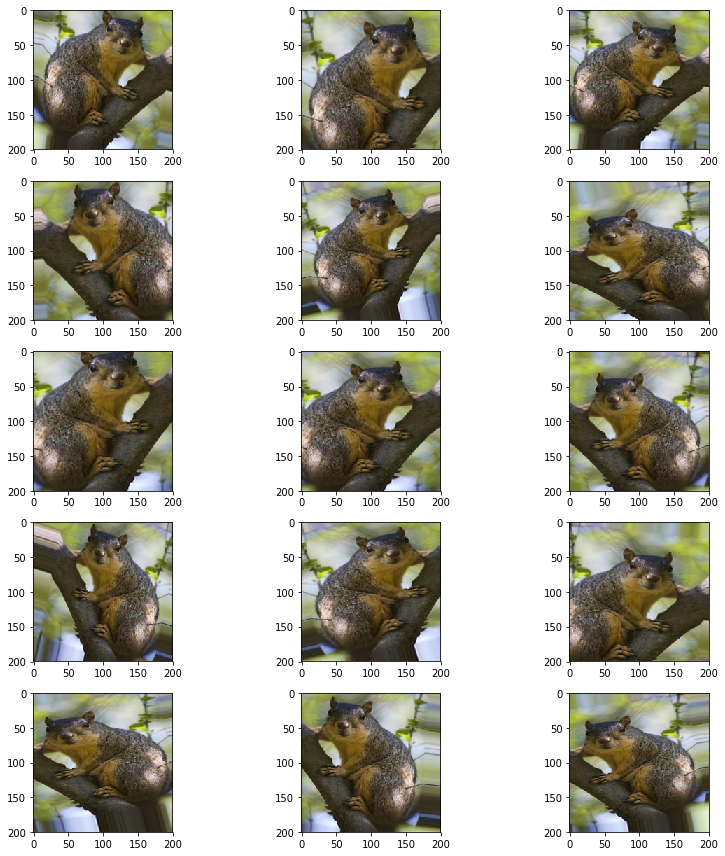

In [17]:
# Sample generator image
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

# MODEL_FILE = 'filename.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
# model.save(MODEL_FILE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
320/320 [==============================] - 122s 382ms/step - loss: 0.9417 - acc: 0.7075 - val_loss: 0.3894 - val_acc: 0.9146
Epoch 2/5
320/320 [==============================] - 114s 357ms/step - loss: 0.6431 - acc: 0.8011 - val_loss: 0.4220 - val_acc: 0.9185
Epoch 3/5
320/320 [==============================] - 121s 378ms/step - loss: 0.5944 - acc: 0.8050 - val_loss: 0.3865 - val_acc: 0.9227
Epoch 4/5
320/320 [==============================] - 121s 378ms/step - loss: 0.5880 - acc: 0.8169 - val_loss: 0.3514 - val_acc: 0.9346
Epoch 5/5
320/320 [==============================] - 120s 377ms/step - loss: 0.5834 - acc: 0.8150 - val_loss: 0.4416 - val_acc: 0.9258


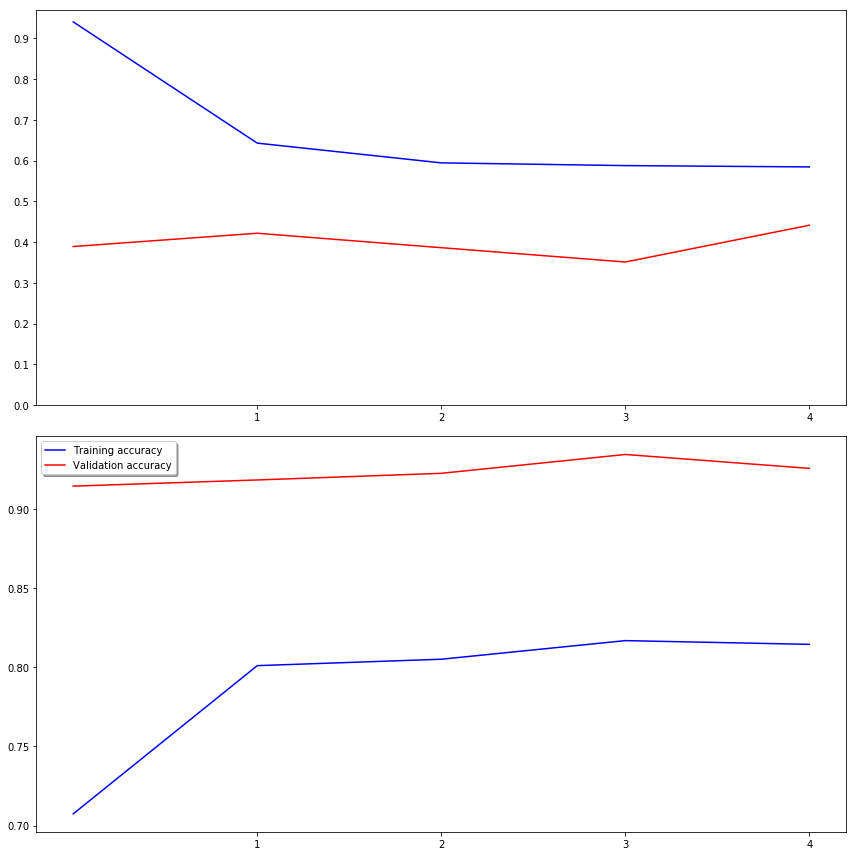

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [0]:
test_filenames = os.listdir("colab-examples/data/animals-10/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [21]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "colab-examples/data/animals-10/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


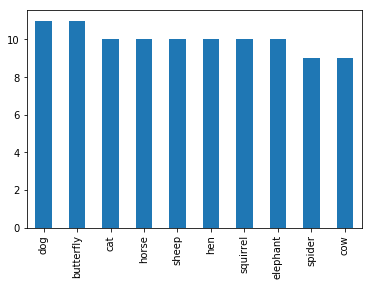

In [25]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'].value_counts().plot.bar()

/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


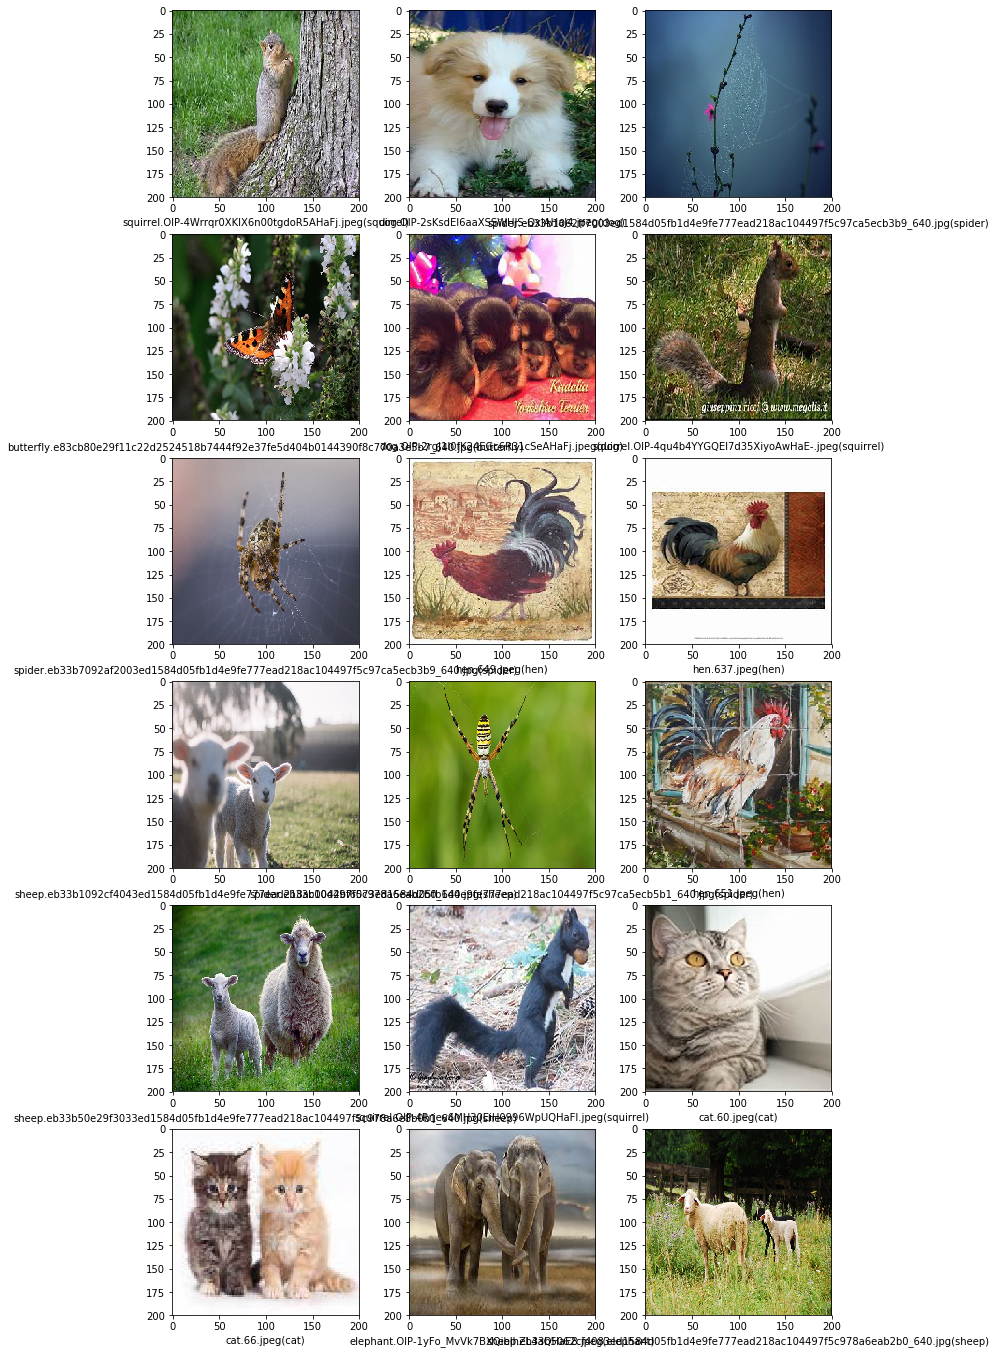

In [26]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("colab-examples/data/animals-10/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()